##  Evalue la qualité de la prédiction d'un modèle / d'une config en regards des métriques obtenues sur différents pas de temps

In [2]:
# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern
from examples.train_model_on_k_fold_validation import load_configuration

## Load Config from HP tuning
```trial_id = 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523'
# "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"
# "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963"
# 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_05_04_80480'
# "subway_in_STGCN_MSELoss_2025_01_06_08_00_94523"
args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

### Evaluate config :

Trial id:  subway_in_STGCN_MSELoss_2025_01_06_08_00_94523

>>>> Load best CONFIG



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([3420, 40, 7])/torch.Size([3420, 40, 1]) Train/Valid/Test 2052 684 683

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
----------------------------------------
Fold n°0

Init Dataset:  torch.Size([1183, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  47

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([3420, 40, 7])/torch.Size([3420, 40, 1]) Train/Valid/Test 2052 684 683

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
----------------------------------------
Fold n°0

Init Dataset:  torch.Size([1183, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  47

Loading BokehJS ...

Loading BokehJS ...

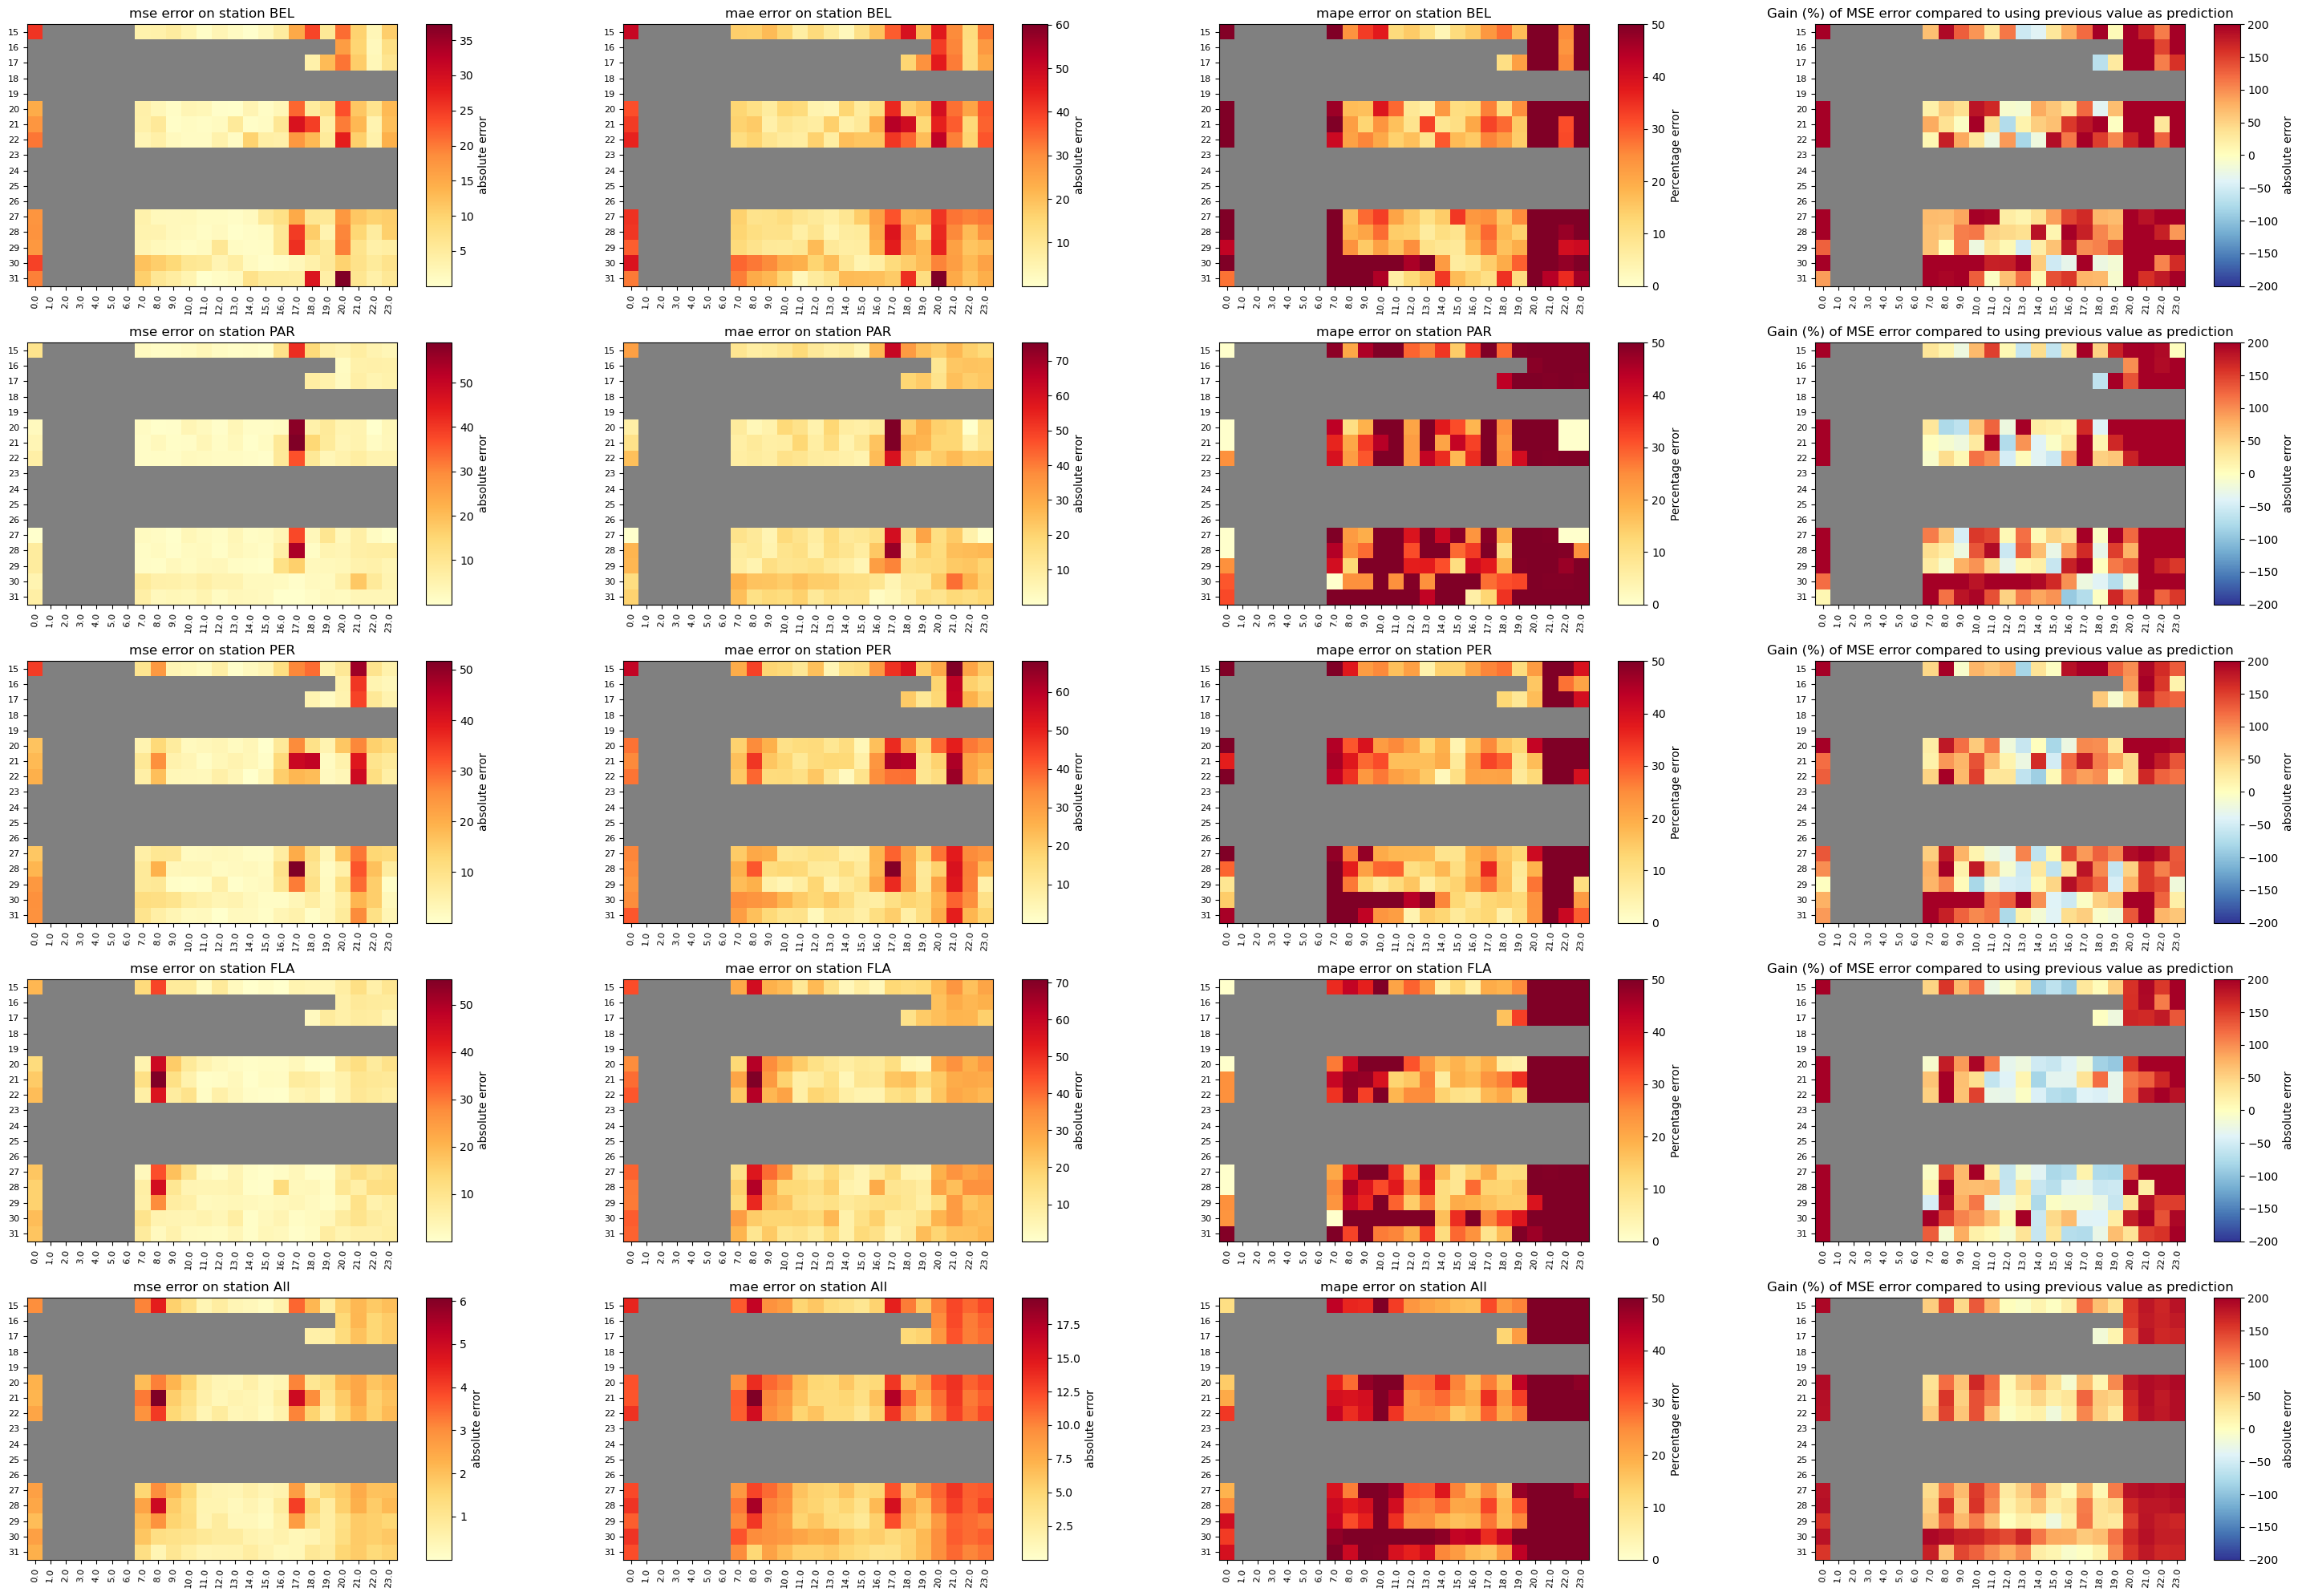

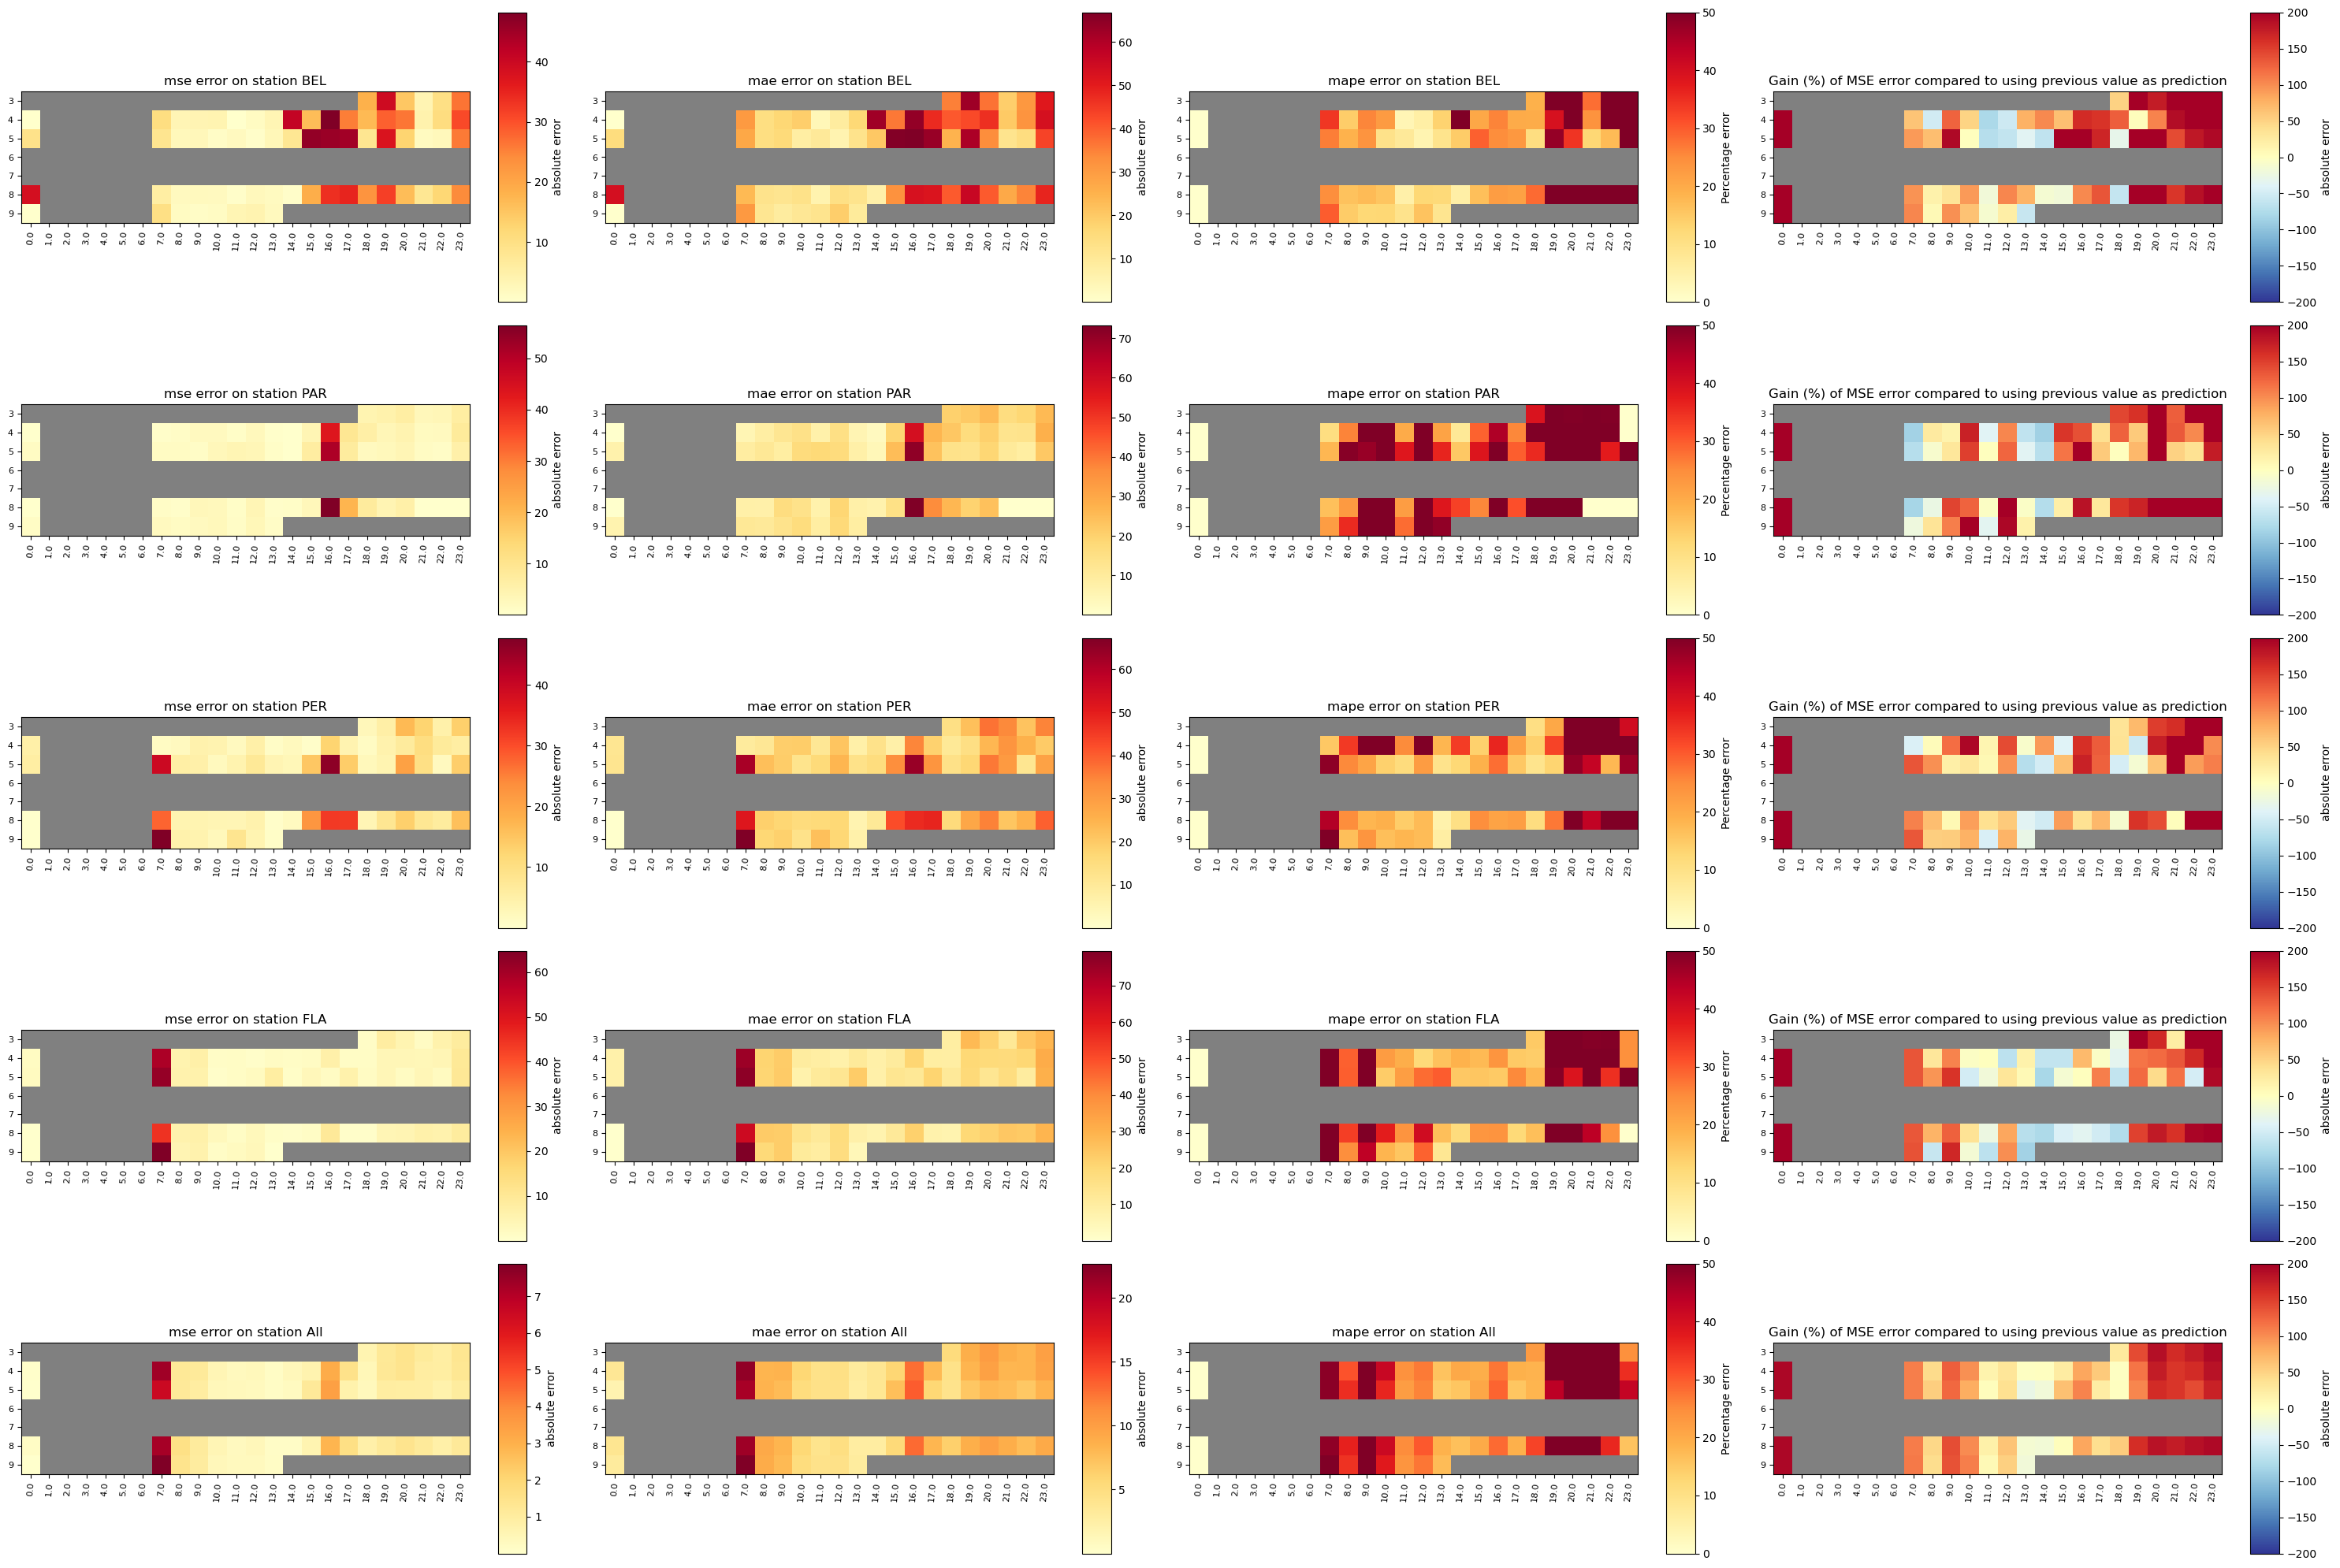

In [4]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={}
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])


    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

In [13]:
trial_id = 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192'
args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
training_mode_to_visualise = ['test','valid','train']
modification ={}
#modification = {'epochs':1}


(trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                station = station,modification=modification,
                                                training_mode_to_visualise=training_mode_to_visualise,
                                                args_init =args_best_model,
                                                fold_to_evaluate = [0])


>>>> Load best CONFIG

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([3420, 40, 7])/torch.Size([3420, 40, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  AMP
U/Utarget size: torch.Size([3420, 34, 7])/torch.Size([3420, 34, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  BEL
U/Utarget size: torch.Size([3420, 36, 7])/torch.Size([3420, 36, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  BRO
U/Utarget size: torch.Size([3420, 30, 7])/torch.Size([3420, 30, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  COR
U/Utarget size: torch.Size([3420, 39, 7])/torch.Size([3420, 39, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  CUI
U/Utarget size: torch.Size([3420, 67, 7])/torch.Size([3420, 67, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  CUS
U/Utarget size: torch.Size([3420, 21, 7])/torch.Size([3420, 21, 1]) Train/Valid/Test 2052 684 683
Spatial unit:  FLA
U/Utarget size: torch.Size([3420, 32, 7])/torch.Siz

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 0 
 min\epoch : 0.05
Estimated time for training: 4.6min 

Training Throughput:507.09 sequences per seconds
>>> Training complete in: 0:03:40.232116
>>> Training performance time: min 0.05345916748046875 avg 0.061142921447753906 seconds (+/- 0.0036612558504332616)
>>> Loading performance time: min 0.002732515335083008 avg 0.04222243864520985 seconds (+/- 0.08674452249727282)
>>> Forward performance time: 0.02245404134121433 seconds (+/- 0.0013647592237142558)
>>> Backward performance time: 0.03345115655383132 seconds (+/- 0.003214794706776803)
>>> Plotting performance time: 4.0145835491141885e-06 seconds (+/- 7.507151898211183e-06)
>>> Saving performance time: 0.8301206049711808 seconds (+/- 0.18835665847009384)
>>> PI-tracking performance time: 3.6918755733605586e-06 seconds (+/- 1.3754101771881607e-06)
>>> Scheduler-update performance time: 4.1812357276377054e-05 seconds (+/- 1.7249441801957154e-05)
>>> Peak Power during training: 110.746 W)
>>> Validation time: 0:00:00.217758

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

## Load config defined 'by hand' :

In [6]:
dataset_names = ["subway_in"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['BEL','PAR','AMP','FLA']   # 'BON'  #'GER'
# ...

modification = {'epochs' : 1, #100
                'lr':4e-4}
training_mode_to_visualise = ['test']

(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station = station,modification=modification,training_mode_to_visualise=training_mode_to_visualise)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([3420, 40, 7])/torch.Size([3420, 40, 1]) Train/Valid/Test 2052 684 683

>>>>>>> SELF args train/valid/test:  0.6 0.2 0.19999999999999996
>>>>>>> train/valid/test:  0.6 0.2 0.19999999999999996
first_train_date:  2019-03-17 00:00:00
last_train_date:  2019-05-01 15:00:00
first_predicted_train_date:  2019-03-18 00:00:00
last_predicted_train_date:  2019-05-01 15:15:00
first_test_date:  2019-05-14 00:30:00
last_test_date:  2019-05-31 23:30:00
first_predicted_test_date:  2019-05-15 00:30:00
last_predicted_test_date:  2019-05-31 23:45:00
----------------------------------------
Fold n°0

Init Dataset:  torch.Size([1183, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  47320 

U/Utarget size: torch.Size([1087, 40, 7])/torch.Size([1087, 40, 1]) Train/Valid 815 271
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

U/Utarget size: torch.Size([3420, 40, 7])/torch.Size([3420, 40, 1]) Train/Valid/Test 2052 684 683

>>>>>>> SELF args train/valid/test:  0.6 0.2 0.19999999999999996
>>>>>>> train/valid/test:  0.6 0.2 0.19999999999999996
first_train_date:  2019-03-17 00:00:00
last_train_date:  2019-05-01 15:00:00
first_predicted_train_date:  2019-03-18 00:00:00
last_predicted_train_date:  2019-05-01 15:15:00
first_test_date:  2019-05-14 00:30:00
last_test_date:  2019-05-31 23:30:00
first_predicted_test_date:  2019-05-15 00:30:00
last_predicted_test_date:  2019-05-31 23:45:00
----------------------------------------
Fold n°0

Init Dataset:  torch.Size([1183, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  47320 

U/Utarget size: torch.Size([1087, 40, 7])/torch.Size([1087, 40, 1]) Train/Valid 815 271


Loading BokehJS ...

In [ ]:
dataset_names = ["subway_in","subway_out"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['BEL','PAR','AMP','FLA']   # 'BON'  #'GER'
# ...

modification = {'epochs' : 200, #100
                'lr':4e-4,
                #'set_spatial_units': station,#['CHA','GER','BON','SOI'],
                #'TE_concatenation_late':False,
                #'TE_concatenation_early':True,   
                #'TE_embedding_dim' : 16, # 3
                #'TE_multi_embedding' : True , 
                'vision_model_name': 'VariableSelectionNetwork',
                'vision_concatenation_early':True,   
                'vision_concatenation_late':True,
                           }
training_mode_to_visualise = ['test']
(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station = station,modification=modification,training_mode_to_visualise=training_mode_to_visualise)

# Init
if False:
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(ds.spatial_unit)),
                                                    limit_percentage_error = limit_percentage_error)